<a href="https://colab.research.google.com/github/SHINGSkywallker/test/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
!pip -q install gspread gspread_dataframe google-auth google-auth-oauthlib google-auth-httplib2 \
               gradio pandas beautifulsoup4 google-generativeai python-dateutil

In [91]:
import os, time, uuid, re, json, datetime
from datetime import datetime as dt, timedelta
from dateutil.tz import gettz
import pandas as pd
import gradio as gr
import requests
from bs4 import BeautifulSoup

import google.generativeai as genai

# Google Auth & Sheets
from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.auth import default

In [92]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [93]:
from google.colab import userdata

# 從 Colab Secrets 中獲取 API 金鑰
api_key = userdata.get('GOOGLE_API_KEY')

# 使用獲取的金鑰配置 genai
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-flash')

In [94]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/1seJsvAgNfAOQhfAzd5_8Xo28owKUnlTPAbDM5yDQLgU/edit?gid=0#gid=0"
WORKSHEET_NAME = "工作表1"
TIMEZONE = "Asia/Taipei"

In [95]:
import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url(SHEET_URL)


# 從 gsheets 的 All-whiteboard-device 載入 sheets
sh = gsheets.worksheet(WORKSHEET_NAME).get_all_values()
# 將 sheets1 資料載入 pd 的 DataFrame 進行分析
df = pd.DataFrame(sh[1:], columns=sh[0])
# 取得最前面的5筆資料
df.head()


""


In [96]:
# 測試將 tasks_df 寫入 Google Sheet
try:
    write_df(ws_tasks, tasks_df, TASKS_HEADER)
    print("✅ tasks_df 已嘗試寫入 Google Sheet。請檢查您的 Sheet 查看資料是否已更新。")
except Exception as e:
    print(f"⚠️ 寫入 Google Sheet 時發生錯誤: {e}")

✅ tasks_df 已嘗試寫入 Google Sheet。請檢查您的 Sheet 查看資料是否已更新。


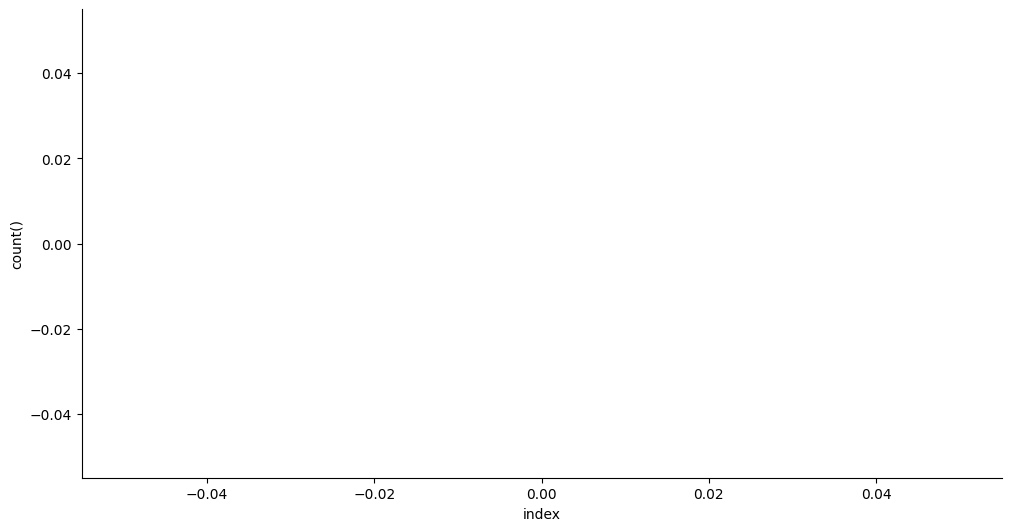

In [97]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

In [98]:
def ensure_spreadsheet(name):
    try:
        sh = gc.open(name)  # returns gspread.models.Spreadsheet
    except gspread.SpreadsheetNotFound:
        sh = gc.create(name)
    return sh

sh = ensure_spreadsheet(WORKSHEET_NAME)

In [99]:
def ensure_worksheet(sh, title, header):
    try:
        ws = sh.worksheet(title)
    except gspread.WorksheetNotFound:
        ws = sh.add_worksheet(title=title, rows="1000", cols=str(len(header)+5))
        ws.update([header])
    # 若沒有表頭就補上
    data = ws.get_all_values()
    if not data or (data and data[0] != header):
        ws.clear()
        ws.update([header])
    return ws

TASKS_HEADER = [
    "id","task","status","priority","est_min","start_time","end_time",
    "actual_min","pomodoros","due_date","labels","notes",
    "created_at","updated_at","completed_at","planned_for"
]
LOGS_HEADER = [
    "log_id","task_id","phase","start_ts","end_ts","minutes","cycles","note"
]
CLIPS_HEADER = ["clip_id","url","selector","text","href","created_at","added_to_task"]

ws_tasks = ensure_worksheet(sh, "tasks", TASKS_HEADER)
ws_logs  = ensure_worksheet(sh, "pomodoro_logs", LOGS_HEADER)
ws_clips = ensure_worksheet(sh, "web_clips", CLIPS_HEADER)

def tznow():
    return dt.now(gettz(TIMEZONE))

def read_df(ws, header):
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    if df is None or df.empty:
        return pd.DataFrame(columns=header)
    df = df.fillna("")
    # 保證欄位齊全
    for c in header:
        if c not in df.columns:
            df[c] = ""
    # 型別微調
    if "est_min" in df.columns:
        df["est_min"] = pd.to_numeric(df["est_min"], errors="coerce").fillna(0).astype(int)
    if "actual_min" in df.columns:
        df["actual_min"] = pd.to_numeric(df["actual_min"], errors="coerce").fillna(0).astype(int)
    if "pomodoros" in df.columns:
        df["pomodoros"] = pd.to_numeric(df["pomodoros"], errors="coerce").fillna(0).astype(int)
    return df[header]

def write_df(ws, df, header):
    if df.empty:
        ws.clear()
        ws.update([header])
        return
    # 轉字串避免 gspread 型別問題
    df_out = df.copy()
    for c in df_out.columns:
        df_out[c] = df_out[c].astype(str)
    ws.clear()
    ws.update([header] + df_out.values.tolist())

def refresh_all():
    return (
        read_df(ws_tasks, TASKS_HEADER).copy(),
        read_df(ws_logs, LOGS_HEADER).copy(),
        read_df(ws_clips, CLIPS_HEADER).copy()
    )

tasks_df, logs_df, clips_df = refresh_all()

def add_task(task, priority, est_min, due_date, labels, notes, planned_for):
    global tasks_df
    _now = tznow().isoformat()
    new = pd.DataFrame([{
        "id": str(uuid.uuid4())[:8],
        "task": task.strip(),
        "status": "todo",
        "priority": priority or "M",
        "est_min": int(est_min) if est_min else 25,
        "start_time": "",
        "end_time": "",
        "actual_min": 0,
        "pomodoros": 0,
        "due_date": due_date or "",
        "labels": labels or "",
        "notes": notes or "",
        "created_at": _now,
        "updated_at": _now,
        "completed_at": "",
        "planned_for": planned_for or ""  # 可填 today / tomorrow / 空白
    }])
    tasks_df = pd.concat([tasks_df, new], ignore_index=True)
    write_df(ws_tasks, tasks_df, TASKS_HEADER)
    return "✅ 已新增任務", tasks_df

def update_task_status(task_id, new_status):
    global tasks_df
    idx = tasks_df.index[tasks_df["id"] == task_id]
    if len(idx)==0:
        return "⚠️ 找不到任務", tasks_df
    i = idx[0]
    tasks_df.loc[i, "status"] = new_status
    tasks_df.loc[i, "updated_at"] = tznow().isoformat()
    if new_status == "done" and not tasks_df.loc[i, "completed_at"]:
        tasks_df.loc[i, "completed_at"] = tznow().isoformat()
    write_df(ws_tasks, tasks_df, TASKS_HEADER)
    return "✅ 狀態已更新", tasks_df

def mark_done(task_id):
    return update_task_status(task_id, "done")

def recalc_task_actuals(task_id):
    """根據 logs_df 回寫 actual_min 與 pomodoros"""
    global tasks_df, logs_df
    work_logs = logs_df[(logs_df["task_id"]==task_id) & (logs_df["phase"]=="work")]
    total_min = work_logs["minutes"].astype(float).sum() if not work_logs.empty else 0
    pomos = int(round(total_min / 25.0))
    idx = tasks_df.index[tasks_df["id"]==task_id]
    if len(idx)==0: return
    i = idx[0]
    tasks_df.loc[i,"actual_min"] = int(total_min)
    tasks_df.loc[i,"pomodoros"] = pomos
    tasks_df.loc[i,"updated_at"] = tznow().isoformat()

def list_task_choices():
    global tasks_df
    if tasks_df.empty:
        return []
    # 顯示： [status] (P:priority) task  — id
    def row_label(r):
        return f"[{r['status']}] (P:{r['priority']}) {r['task']} — {r['id']}"
    return [(row_label(r), r["id"]) for _, r in tasks_df.iterrows()]

# 我們採「按鈕開始 / 結束」模式（避免後端阻塞），每次按「開始」會先記住 start_ts，
# 按「結束」時計算分鐘並寫入 logs，再回填任務 actual_min / pomodoros。

_active_sessions = {}  # { task_id: {"phase": "work"/"break", "start_ts": iso, "cycles": int} }

def start_phase(task_id, phase, cycles):
    if not task_id: return "⚠️ 請先選擇任務"
    _active_sessions[task_id] = {
        "phase": phase,
        "start_ts": tznow().isoformat(),
        "cycles": int(cycles) if cycles else 1
    }
    return f"▶️ 已開始：{phase}（task: {task_id}）"

def end_phase(task_id, note):
    global logs_df, tasks_df
    if task_id not in _active_sessions:
        return "⚠️ 尚未開始任何階段"
    sess = _active_sessions.pop(task_id)
    start = pd.to_datetime(sess["start_ts"])
    end = tznow()
    minutes = round((end - start).total_seconds() / 60.0, 2)
    log = pd.DataFrame([{
        "log_id": str(uuid.uuid4())[:8],
        "task_id": task_id,
        "phase": sess["phase"],
        "start_ts": start.isoformat(),
        "end_ts": end.isoformat(),
        "minutes": minutes,
        "cycles": int(sess["cycles"]),
        "note": note or ""
    }])
    logs_df = pd.concat([logs_df, log], ignore_index=True)
    write_df(ws_logs, logs_df, LOGS_HEADER)

    # 回填任務
    if sess["phase"] == "work":
        recalc_task_actuals(task_id)
        write_df(ws_tasks, tasks_df, TASKS_HEADER)

    return f"⏹️ 已結束：{sess['phase']}，紀錄 {minutes} 分鐘"

# AI 計畫（Gemini；無金鑰則規則式）
def generate_today_plan():
    global tasks_df
    # 以「due_date 是今天」或「planned_for = today」且不是 done 的任務為計畫清單
    today = tznow().date().isoformat()
    cand = tasks_df[
        ((tasks_df["due_date"]==today) | (tasks_df["planned_for"].str.lower()=="today")) &
        (tasks_df["status"]!="done")
    ].copy()
    if cand.empty:
        return "📭 今天沒有標記的任務。請在 Tasks 分頁把任務的 due_date 設為今天或 planned_for 設為 today。"

    # 先依 priority（H>M>L）+ est_min 排序
    pr_order = {"H":0, "M":1, "L":2}
    cand["p_ord"] = cand["priority"].map(pr_order).fillna(3)
    cand = cand.sort_values(["p_ord","est_min"], ascending=[True, True])

    # 嘗試 Gemini
    api_key = os.environ.get("GOOGLE_API_KEY","").strip()
    if api_key:
        genai.configure(api_key=api_key)
        sys_prompt = (
            "你是一位任務規劃助理。請把輸入的任務（含估時與優先級）排成三段：morning、afternoon、evening，"
            "並給出每段的重點、順序、每項的時間預估與備註。總時數請大致符合任務估時總和。"
            "回傳以 Markdown 條列，格式：\n"
            "### Morning\n- [任務ID] 任務名稱（預估 xx 分）— 備註\n..."
            "### Afternoon\n...\n### Evening\n...\n"
        )
        items = []
        for _, r in cand.iterrows():
            items.append({
                "id": r["id"], "task": r["task"], "est_min": int(r["est_min"]),
                "priority": r["priority"]
            })
        user_content = json.dumps({"today": today, "tasks": items}, ensure_ascii=False)
        try:
            model = genai.GenerativeModel("gemini-2.5-flash")
            resp = model.generate_content(sys_prompt + "\n\n" + user_content)
            plan_md = resp.text
        except Exception as e:
            plan_md = f"⚠️ Gemini 失敗：{e}\n\n改用規則式規劃。"
    else:
        plan_md = "🔧 未設定 GOOGLE_API_KEY，使用規則式規劃。\n\n"

    # 規則式：把高優先任務平均切到上午/下午/晚上
    buckets = {"morning": [], "afternoon": [], "evening": []}
    total = len(cand)
    for i, (_, r) in enumerate(cand.iterrows()):
        if i % 3 == 0:
            buckets["morning"].append(r)
        elif i % 3 == 1:
            buckets["afternoon"].append(r)
        else:
            buckets["evening"].append(r)

    def sec_md(name, rows):
        if not rows: return f"### {name.title()}\n（無）\n"
        lines = [f"### {name.title()}"]
        for r in rows:
            lines.append(f"- [{r['id']}] {r['task']}（預估 {int(r['est_min'])} 分，P:{r['priority']}）")
        return "\n".join(lines) + "\n"

    rule_md = sec_md("morning", buckets["morning"]) + "\n" + \
              sec_md("afternoon", buckets["afternoon"]) + "\n" + \
              sec_md("evening", buckets["evening"])

    return (plan_md + "\n---\n" + rule_md).strip()

# 今日完成率
def today_summary():
    global tasks_df
    today = tznow().date().isoformat()
    planned = tasks_df[
        ((tasks_df["due_date"]==today) | (tasks_df["planned_for"].str.lower()=="today"))
    ]
    done = planned[planned["status"]=="done"]
    total = len(planned)
    done_n = len(done)
    rate = (done_n/total*100) if total>0 else 0
    return f"📅 今日計畫任務：{total}；✅ 完成：{done_n}；📈 完成率：{rate:.1f}%"

# =========================
# 爬蟲：擷取文字或連結並可加入任務
# =========================
def crawl(url, selector, mode, limit):
    try:
        resp = requests.get(url, timeout=15, headers={"User-Agent":"Mozilla/5.0"})
        resp.raise_for_status()
    except Exception as e:
        return pd.DataFrame(columns=CLIPS_HEADER), f"⚠️ 請求失敗：{e}"

    soup = BeautifulSoup(resp.text, "html.parser")
    nodes = soup.select(selector)
    rows = []
    for i, n in enumerate(nodes[:int(limit) if limit else 20]):
        text = n.get_text(strip=True) if mode in ("text","both") else ""
        href = n.get("href") if mode in ("href","both") else ""
        # 相對連結處理
        if href and href.startswith("/"):
            from urllib.parse import urljoin
            href = urljoin(url, href)
        rows.append({
            "clip_id": str(uuid.uuid4())[:8],
            "url": url,
            "selector": selector,
            "text": text,
            "href": href,
            "created_at": tznow().isoformat(),
            "added_to_task": ""
        })
    df = pd.DataFrame(rows, columns=CLIPS_HEADER)
    return df, f"✅ 擷取 {len(df)} 筆"

def add_clips_as_tasks(clip_ids, default_priority, est_min):
    global clips_df, tasks_df
    if not clip_ids:
        return "⚠️ 請先勾選要加入的爬蟲項目", clips_df, tasks_df
    sel = clips_df[clips_df["clip_id"].isin(clip_ids)]
    _now = tznow().isoformat()
    new_tasks = []
    for _, r in sel.iterrows():
        title = r["text"] or r["href"] or "（未命名）"
        note = f"來源：{r['url']}\n選擇器：{r['selector']}\n連結：{r['href']}"
        new_tasks.append({
            "id": str(uuid.uuid4())[:8],
            "task": title[:120],
            "status": "todo",
            "priority": default_priority or "M",
            "est_min": int(est_min) if est_min else 25,
            "start_time": "",
            "end_time": "",
            "actual_min": 0,
            "pomodoros": 0,
            "due_date": "",
            "labels": "from:crawler",
            "notes": note,
            "created_at": _now,
            "updated_at": _now,
            "completed_at": "",
            "planned_for": ""
        })
    if new_tasks:
        tasks_df = pd.concat([tasks_df, pd.DataFrame(new_tasks)], ignore_index=True)
        # 標記已加入
        clips_df.loc[clips_df["clip_id"].isin(clip_ids), "added_to_task"] = "yes"
        write_df(ws_tasks, tasks_df, TASKS_HEADER)
        write_df(ws_clips, clips_df, CLIPS_HEADER)
        return f"✅ 已加入 {len(new_tasks)} 項為任務", clips_df, tasks_df
    return "⚠️ 無可加入項目", clips_df, tasks_df

# =========================
# Gradio 介面
# =========================
def _refresh():
    global tasks_df, logs_df, clips_df
    tasks_df, logs_df, clips_df = refresh_all()
    return tasks_df, logs_df, clips_df, list_task_choices(), today_summary()

with gr.Blocks(title="待辦清單＋番茄鐘＋AI 計畫（Sheet/Gradio/爬蟲）") as demo:
    gr.Markdown("# ✅ 待辦清單與番茄鐘（Google Sheet＋Gradio＋Crawler＋AI 計畫）")
    with gr.Row():
        btn_refresh = gr.Button("🔄 重新整理（Sheet → App）")
        out_summary = gr.Markdown(today_summary())

    with gr.Tab("Tasks"):
        with gr.Row():
            with gr.Column(scale=2):
                task = gr.Textbox(label="任務名稱", placeholder="寫 HW3 報告 / 修正 SQL / …")
                priority = gr.Dropdown(["H","M","L"], value="M", label="優先級")
                est_min = gr.Number(value=25, label="預估時間（分鐘）", precision=0)
                due_date = gr.Textbox(label="到期日（YYYY-MM-DD，可空白）")
                labels = gr.Textbox(label="標籤（逗號分隔，可空白）")
                notes = gr.Textbox(label="備註（可空白）")
                planned_for = gr.Dropdown(["","today","tomorrow"], value="", label="規劃歸屬")
                btn_add = gr.Button("➕ 新增任務")
                msg_add = gr.Markdown()
            with gr.Column(scale=3):
                grid_tasks = gr.Dataframe(value=tasks_df, label="任務清單（直接從 Sheet 來）", interactive=False)

        with gr.Row():
            task_choice = gr.Dropdown(choices=list_task_choices(), label="選取任務（用於更新）")
            new_status = gr.Dropdown(["todo","in-progress","done"], value="in-progress", label="更新狀態")
            btn_update = gr.Button("✏️ 更新狀態")
            btn_done = gr.Button("✅ 直接標記完成")
            msg_update = gr.Markdown()

    with gr.Tab("Pomodoro"):
        with gr.Row():
            sel_task = gr.Dropdown(choices=list_task_choices(), label="選擇任務")
            cycles = gr.Number(value=1, precision=0, label="番茄數（僅作紀錄）")
        with gr.Row():
            btn_start_work = gr.Button("▶️ 開始工作")
            note_work = gr.Textbox(label="工作備註（可空白）")
            btn_end_work = gr.Button("⏹️ 結束工作並記錄")
        with gr.Row():
            btn_start_break = gr.Button("🍵 開始休息")
            note_break = gr.Textbox(label="休息備註（可空白）")
            btn_end_break = gr.Button("⏹️ 結束休息並記錄")
        msg_pomo = gr.Markdown()
        grid_logs = gr.Dataframe(value=logs_df, label="番茄鐘紀錄", interactive=False)

    with gr.Tab("AI Plan"):
        gr.Markdown("把**今天的任務**排成 **morning / afternoon / evening** 三段行動計畫。若未設 GOOGLE_API_KEY，會用規則式。")
        btn_plan = gr.Button("🧠 產生今日計畫")
        out_plan = gr.Markdown()

    with gr.Tab("Crawler"):
        url = gr.Textbox(label="目標 URL", placeholder="https://example.com")
        selector = gr.Textbox(label="CSS Selector", placeholder="a.news-item / h2.title / div.card a")
        mode = gr.Radio(["text","href","both"], value="text", label="擷取內容")
        limit = gr.Number(value=20, precision=0, label="最多擷取幾筆")
        btn_crawl = gr.Button("🕷️ 開始擷取")
        msg_crawl = gr.Markdown()
        grid_clips = gr.Dataframe(value=clips_df, label="擷取結果（會同步寫入 Sheet）", interactive=True)
        clip_ids = gr.Textbox(label="要加入任務的 clip_id（多個以逗號分隔）")
        default_priority = gr.Dropdown(["H","M","L"], value="L", label="新增任務優先級")
        clip_est = gr.Number(value=25, precision=0, label="新增任務預估分鐘")
        btn_add_clips = gr.Button("➕ 將勾選的擷取項目加入為任務")
        msg_add_clips = gr.Markdown()

    with gr.Tab("Summary"):
        btn_summary = gr.Button("📊 重新計算今日完成率")
        out_summary2 = gr.Markdown()

    # === 綁定動作 ===
    btn_refresh.click(_refresh, outputs=[grid_tasks, grid_logs, grid_clips, task_choice, out_summary])

    btn_add.click(
        add_task,
        inputs=[task, priority, est_min, due_date, labels, notes, planned_for],
        outputs=[msg_add, grid_tasks]
    )

    btn_update.click(
        update_task_status,
        inputs=[task_choice, new_status],
        outputs=[msg_update, grid_tasks]
    )

    btn_done.click(
        mark_done,
        inputs=[task_choice],
        outputs=[msg_update, grid_tasks]
    )

    btn_start_work.click(
        start_phase, inputs=[sel_task, gr.State("work"), cycles], outputs=[msg_pomo]
    )
    btn_end_work.click(
        end_phase, inputs=[sel_task, note_work], outputs=[msg_pomo]
    )
    btn_start_break.click(
        start_phase, inputs=[sel_task, gr.State("break"), cycles], outputs=[msg_pomo]
    )
    btn_end_break.click(
        end_phase, inputs=[sel_task, note_break], outputs=[msg_pomo]
    )

    btn_plan.click(generate_today_plan, outputs=[out_plan])

    def _crawl_and_save(u, s, m, l):
        df, msg = crawl(u, s, m, l)
        # 寫入 web_clips（覆蓋式追加：合併舊資料）
        global clips_df
        if not df.empty:
            clips_df = pd.concat([clips_df, df], ignore_index=True)
            write_df(ws_clips, clips_df, CLIPS_HEADER)
        return msg, clips_df

    btn_crawl.click(_crawl_and_save, inputs=[url, selector, mode, limit], outputs=[msg_crawl, grid_clips])

    def _add_clips(clip_ids_str, pr, est):
        ids = [c.strip() for c in (clip_ids_str or "").split(",") if c.strip()]
        msg, new_clips, new_tasks = add_clips_as_tasks(ids, pr, est)
        return msg, new_clips, new_tasks

    btn_add_clips.click(
        _add_clips,
        inputs=[clip_ids, default_priority, clip_est],
        outputs=[msg_add_clips, grid_clips, grid_tasks]
    )

    btn_summary.click(today_summary, outputs=[out_summary2])

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c89e441fffebf22bcf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [100]:
with gr.Blocks(title="待辦清單＋番茄鐘＋AI 計畫（Sheet/Gradio/爬蟲）") as demo:
    gr.Markdown("# ✅ 待辦清單與番茄鐘（Google Sheet＋Gradio＋Crawler＋AI 計畫）")
    with gr.Row():
        btn_refresh = gr.Button("🔄 重新整理（Sheet → App）")
        out_summary = gr.Markdown(today_summary())

    with gr.Tab("Tasks"):
        with gr.Row():
            with gr.Column(scale=2):
                task = gr.Textbox(label="任務名稱", placeholder="寫 HW3 報告 / 修正 SQL / …")
                priority = gr.Dropdown(["H","M","L"], value="M", label="優先級")
                est_min = gr.Number(value=25, label="預估時間（分鐘）", precision=0)
                due_date = gr.Textbox(label="到期日（YYYY-MM-DD，可空白）")
                labels = gr.Textbox(label="標籤（逗號分隔，可空白）")
                notes = gr.Textbox(label="備註（可空白）")
                planned_for = gr.Dropdown(["","today","tomorrow"], value="", label="規劃歸屬")
                btn_add = gr.Button("➕ 新增任務")
                msg_add = gr.Markdown()
            with gr.Column(scale=3):
                grid_tasks = gr.Dataframe(value=tasks_df, label="任務清單（直接從 Sheet 來）", interactive=False)

        with gr.Row():
            task_choice = gr.Dropdown(choices=list_task_choices(), label="選取任務（用於更新）")
            new_status = gr.Dropdown(["todo","in-progress","done"], value="in-progress", label="更新狀態")
            btn_update = gr.Button("✏️ 更新狀態")
            btn_done = gr.Button("✅ 直接標記完成")
            msg_update = gr.Markdown()

        # 新增刪除任務區塊
        with gr.Row():
            delete_task_choice = gr.Dropdown(choices=list_task_choices(), label="選取要刪除的任務")
            btn_delete = gr.Button("🗑️ 刪除任務")
            msg_delete = gr.Markdown()


    with gr.Tab("Pomodoro"):
        with gr.Row():
            sel_task = gr.Dropdown(choices=list_task_choices(), label="選擇任務")
            cycles = gr.Number(value=1, precision=0, label="番茄數（僅作紀錄）")
        with gr.Row():
            btn_start_work = gr.Button("▶️ 開始工作")
            note_work = gr.Textbox(label="工作備註（可空白）")
            btn_end_work = gr.Button("⏹️ 結束工作並記錄")
        with gr.Row():
            btn_start_break = gr.Button("🍵 開始休息")
            note_break = gr.Textbox(label="休息備註（可空白）")
            btn_end_break = gr.Button("⏹️ 結束休息並記錄")
        msg_pomo = gr.Markdown()
        grid_logs = gr.Dataframe(value=logs_df, label="番茄鐘紀錄", interactive=False)

    with gr.Tab("AI Plan"):
        gr.Markdown("把**今天的任務**排成 **morning / afternoon / evening** 三段行動計畫。若未設 GOOGLE_API_KEY，會用規則式。")
        btn_plan = gr.Button("🧠 產生今日計畫")
        out_plan = gr.Markdown()

    with gr.Tab("Crawler"):
        url = gr.Textbox(label="目標 URL", placeholder="https://example.com")
        selector = gr.Textbox(label="CSS Selector", placeholder="a.news-item / h2.title / div.card a")
        mode = gr.Radio(["text","href","both"], value="text", label="擷取內容")
        limit = gr.Number(value=20, precision=0, label="最多擷取幾筆")
        btn_crawl = gr.Button("🕷️ 開始擷取")
        msg_crawl = gr.Markdown()
        grid_clips = gr.Dataframe(value=clips_df, label="擷取結果（會同步寫入 Sheet）", interactive=True)
        clip_ids = gr.Textbox(label="要加入任務的 clip_id（多個以逗號分隔）")
        default_priority = gr.Dropdown(["H","M","L"], value="L", label="新增任務優先級")
        clip_est = gr.Number(value=25, precision=0, label="新增任務預估分鐘")
        btn_add_clips = gr.Button("➕ 將勾選的擷取項目加入為任務")
        msg_add_clips = gr.Markdown()

    with gr.Tab("Summary"):
        btn_summary = gr.Button("📊 重新計算今日完成率")
        out_summary2 = gr.Markdown()

    # === 綁定動作 ===
    btn_refresh.click(_refresh, outputs=[grid_tasks, grid_logs, grid_clips, task_choice, out_summary, delete_task_choice, sel_task])

    btn_add.click(
        add_task,
        inputs=[task, priority, est_min, due_date, labels, notes, planned_for],
        outputs=[msg_add, grid_tasks]
    )

    btn_update.click(
        update_task_status,
        inputs=[task_choice, new_status],
        outputs=[msg_update, grid_tasks]
    )

    btn_done.click(
        mark_done,
        inputs=[task_choice],
        outputs=[msg_update, grid_tasks]
    )

    btn_start_work.click(
        start_phase, inputs=[sel_task, gr.State("work"), cycles], outputs=[msg_pomo]
    )
    btn_end_work.click(
        end_phase, inputs=[sel_task, note_work], outputs=[msg_pomo]
    )
    btn_start_break.click(
        start_phase, inputs=[sel_task, gr.State("break"), cycles], outputs=[msg_pomo]
    )
    btn_end_break.click(
        end_phase, inputs=[sel_task, note_break], outputs=[msg_pomo]
    )

    btn_plan.click(generate_today_plan, outputs=[out_plan])

    def _crawl_and_save(u, s, m, l):
        df, msg = crawl(u, s, m, l)
        # 寫入 web_clips（覆蓋式追加：合併舊資料）
        global clips_df
        if not df.empty:
            clips_df = pd.concat([clips_df, df], ignore_index=True)
            write_df(ws_clips, clips_df, CLIPS_HEADER)
        return msg, clips_df

    btn_crawl.click(_crawl_and_save, inputs=[url, selector, mode, limit], outputs=[msg_crawl, grid_clips])

    def _add_clips(clip_ids_str, pr, est):
        ids = [c.strip() for c in (clip_ids_str or "").split(",") if c.strip()]
        msg, new_clips, new_tasks = add_clips_as_tasks(ids, pr, est)
        return msg, new_clips, new_tasks

    btn_add_clips.click(
        _add_clips,
        inputs=[clip_ids, default_priority, clip_est],
        outputs=[msg_add_clips, grid_clips, grid_tasks]
    )

    btn_summary.click(today_summary, outputs=[out_summary2])

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b2176ee265ff5d8399.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
